<a href="https://colab.research.google.com/github/a-woodbury/RxVision/blob/master/Notebooks/RxVision_Technical_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RxVision

RxVision is a image recognition model for identifying medications. The goal is to create a fast, reliable, and scalable solution for clinicians, dispensing pharmacies, and patients to get real-time identification of a capsule or tablet. 

This first version uses a convolutional neural network to distinguish images of medications into 15 classes, in this case specific medications by their National Drug Code (NDC). 

The 15 drugs selected for training were chosen for their ability to be evaluated in the real-world; patients (my friends and family) provided (willingly) images of their medications in their hand or on their counter to showcase how a patient would use this model in reality. Each drug class provided 30 NIH images for training and validation and 1 real-world image for testing. 

The training images were acquired from the NIH dataset, which houses over 130,000 images of 4300+ distinct medications. On average, each medication has 29 images that can be used for training, but there are about 250 with over 50. images. I would have preferred to train on those medications, but no real-world images were available.


# Model Prep


## Import Packages

In [0]:
import pandas as pd
import requests
from IPython.display import Image
from ftplib import FTP #needed to make the request to the server

# packages for processing images
! pip install rawpy
from PIL import Image
from PIL import ImageFile
import rawpy
import imageio
ImageFile.LOAD_TRUNCATED_IMAGES = True


import os, shutil, sys #required for moving files

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from pathlib import Path


import imageio
import imgaug as ia

import pandas as pd
import numpy as np
import pickle
import seaborn as sns

import os
import sys
import warnings
warnings.filterwarnings('ignore')
#!{sys.executable} -m pip install opencv-python

import time
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

#import tensorflow as tf
#from tensorflow import keras

import scipy
from PIL import Image
from scipy import ndimage

#import tensorflow as tf
#from tensorflow import keras
import tensorflow.keras 
from keras import layers
from keras import models
from keras import optimizers
from keras import models
from keras import layers
import multiprocessing

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Model
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras.applications.resnet import ResNet50
from keras.callbacks import CSVLogger

from sklearn.model_selection import RandomizedSearchCV, cross_val_score, GridSearchCV, validation_curve 
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, r2_score, recall_score, precision_score, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV, validation_curve
from sklearn.pipeline import make_pipeline
#from tensorflow.keras import get_default_graph

from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# This code has been tested with TensorFlow 1.6
#import tensorflow as tf
#from tensorflow.examples.tutorials.mnist import input_data
np.random.seed(123)

# Transfer learning with VGG16
# from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.vgg16 import preprocess_input

import random 

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn import metrics
import seaborn as sns

from numpy import loadtxt
from keras.models import load_model

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

## Functions

In [0]:
def model_scores(model):
  '''Return validation accuracy and real-world accuracy after evaluating provided model'''
  model_val_results = model.evaluate(val_generator)
  modelacc = model_val_results[1]
  model_rw_results = model.evaluate(realworld_generator)
  modelrw = model_rw_results[1]
  print('\nValidation Accuracy: ' + str(int(modelacc*100)) + '%' + '\nReal-world Accuracy: ' + str(int(modelrw*100)) + '%')

def model_acc_val_plot(model):
  '''Return train and validation loss and accuracy plots from hist log'''
  class_size =  int(val_generator.samples / len(val_generator.class_indices))
  acc = hist['acc']
  val_acc = hist['val_acc']

  loss = hist['loss']
  val_loss = hist['val_loss']

  epochs_range = range(EPOCHS)

  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plt.plot(range(0,len(hist)), acc, label='Training Accuracy')
  plt.plot(range(0,len(hist)), val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 3, 3)
  plt.plot(range(0,len(hist)), loss, label='Training Loss')
  plt.plot(range(0,len(hist)), val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.savefig('/content/drive/My Drive/RxID2/Images/{}_AccLoss.png'.format(model.name))
  plt.show()

def model_confusion(model):
  '''Return a confusion matrix for predictions made from evaluating the proviced model'''
  labels = list((val_generator.class_indices).values())
  pred = model.predict(val_generator)
  y_pred=np.argmax(pred,axis=1)
  y_true = val_generator.classes

  cf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=labels)

  fig, ax = plt.subplots(figsize=(8,6.75))  
  pal = sns.light_palette("#ffab40", as_cmap=True)
  sns.heatmap(cf_matrix, annot=True,cmap=pal,ax=ax)
  plt.ylabel('Class Actual', fontweight='bold')
  plt.xlabel('Class Predicted', fontweight='bold')
  plt.title('/content/drive/My Drive/RxID2/Images/{}_Confusion Matrix'.format(model.name), fontweight='bold', loc='left')
  plt.savefig('/content/drive/My Drive/RxID2/Images/{}_conf'.format(model.name))

def predict_plot(model):
  '''
  Return an image plot with class, number of correct predictions,
  and predicted classes (ordered by descending frequency)
  '''
  %cd /content/drive/My Drive/RxID2/Data/Download
  labels = list((val_generator.class_indices).values())
  pred = model.predict(val_generator)
  y_pred=np.argmax(pred,axis=1)
  y_true = val_generator.classes
  class_size =  int(val_generator.samples / len(val_generator.class_indices))
  dfx = df[df.TYPE == 'MC_COOKED_CALIBRATED_V1.2']
  samplesdfx = dfx.groupby(['NDC']).min().reset_index()
  sampleslist2 = samplesdfx.FILE.tolist()
  #len(sampleslist2)

  samplefiles = []
  for image in sampleslist2:
      smplsplt = image.split('/')
      keep = smplsplt[-1]
      keep = keep[:-4]
      keep= keep +('.JPG')
      samplefiles.append(keep)

      
  #for file in os.listdir():
  drgimg = os.listdir()
  images = []
  for file in samplefiles:
      data = plt.imread(file)
      images.append(data)
  plt.figure(figsize=(15,15))
  columns = 5

  for i, image in enumerate(images): # iterate through the images in the array 'images'
      k = i * class_size
      j = (i + 1) * class_size
      trues = int(y_true[k:j].mean())
      preds = list(y_pred[k:j]).count(trues)
      lst = list(y_pred[k:j])
      preddict = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0,12:0,13:0,14:0}
      for pred in lst:
          preddict[pred] +=1
      preddict = {k: v for k, v in sorted(preddict.items(), key=lambda item: item[1], reverse=True)}
      for k, v in list(preddict.items()):
          if v == 0:
              del preddict[k]
      predlist = list(preddict.keys())
      dname = df.DRUG[df.FILENAME.str.contains(samplefiles[i][:-4])].tolist()[0] # get the drug name from the df for the image in index i 
      dndc = df.NDC[df.FILENAME.str.contains(samplefiles[i][:-4])].tolist()[0] # get the NDC from the df for the image in index i 
      title = '[' + str(i) + '] ' + ' ' + dname + '\nCorrect: ' + str(preds) + '\nPreds: ' +  ', '.join(map(str,predlist)) # title for each subplot: class, drug name, and NDC
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.suptitle('RxID15 Classes',fontweight='bold',fontsize='large', color= '#ffab40')
      plt.subplots_adjust(hspace=0.2,wspace=0.25, top=.9, bottom=.2) # i believe this is the subplots spacing from each other and within the plot
      plt.margins(tight=True) # not sure which margins this is impacting
      plt.title(title,fontweight='semibold',fontsize='10')
      plt.imshow(image)
      plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
      plt.savefig('/content/drive/My Drive/RxID2/Images/{}_predictions.jpg'.format(model.name),format='jpg',quality=95,dpi=300, bbox='tight',pad_inches = 0) # bbox has always given me the output i wanted...
  %cd ../..

def real_world_predicts(model):
  '''Return predicted classes for real world images using provided model'''
  pred = model.predict(realworld_generator)
  y_pred=np.argmax(pred,axis=1)
  print('\nReal-world predictions 0-14: ', y_pred)

## Data Selection




The dataset includes a [readme](ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Pills/AAREADME) that outlines the dataset



In [9]:
typdict = {'NDC':'str'}
df = pd.read_csv('/content/drive/My Drive/RxID2/directory_of_images.txt',sep='|', dtype=typdict, names=['NDC','PART_#','FILE','TYPE','DRUG'])
df

,NDC,PART_#,FILE,TYPE,DRUG
0,00002322730,1,PillProjectDisc69/images/CLLLLUPGIX7J8MP1WWQ9W...,C3PI_Reference,STRATTERA 10MG
1,00002322730,1,PillProjectDisc98/images/PRNJ-AXZIQ!HUQKJJBP_D...,C3PI_Reference,STRATTERA 10MG
2,00002322730,1,PillProjectDisc10/images/79U-YY6M1UUR6F127ZMAC...,C3PI_Test,STRATTERA 10MG
3,00002322730,1,PillProjectDisc11/images/7WVFV5H74!ELFNQ_GUH92...,C3PI_Test,STRATTERA 10MG
4,00002322730,1,PillProjectDisc20/images/B4CH0R9B7PEQ6GORRX-8X...,C3PI_Test,STRATTERA 10MG
...,...,...,...,...,...
133769,99207046730,1,PillProjectDisc103/images/TY5OVXLLOXV6H4I1TDVT...,MC_COOKED_CALIBRATED_V1.2,SOLODYN 105 MG TAB
133770,99207046730,1,PillProjectDisc31/images/BEIR3XK38EMGSDOZTWMUK...,MC_COOKED_CALIBRATED_V1.2,SOLODYN 105 MG TAB
133771,99207046730,1,PillProjectDisc69/images/CLJ1W40OS0XG5H6IVYT!N...,MC_COOKED_CALIBRATED_V1.2,SOLODYN 105 MG TAB
133772,99207046730,1,PillProjectDisc77/images/CSUHWDZ!XAZSEJHDANMFR...,MC_COOKED_CALIBRATED_V1.2,SOLODYN 105 MG TAB


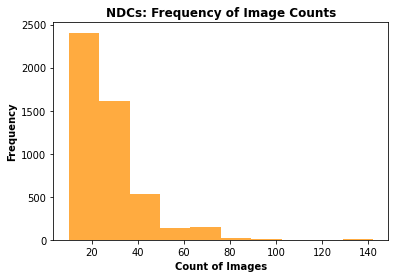

In [0]:
plt.hist(df.NDC.value_counts(), color='#ffab40')
plt.title('NDCs: Frequency of Image Counts', fontweight='bold')
plt.xlabel('Count of Images', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.savefig('NDCs: Frequency of Image Counts')
plt.show()

comment on how most of the drugs in the dataset will have fewer than 50 images

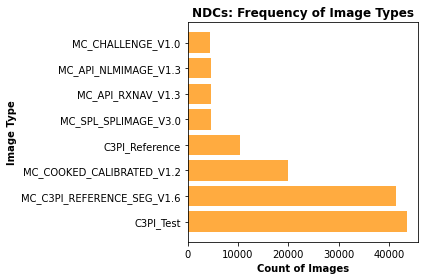

In [0]:
plt.barh(df.TYPE.value_counts().index,df.TYPE.value_counts().values, color='#ffab40')
plt.title('NDCs: Frequency of Image Types', fontweight='bold')
plt.xlabel('Count of Images', fontweight='bold')
plt.ylabel('Image Type', fontweight='bold',)
plt.tight_layout()
plt.savefig('Image Types')
plt.show()

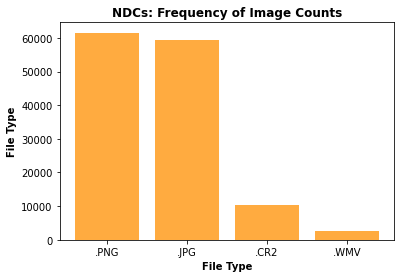

In [0]:
plt.bar(df.FILETYPE.value_counts().index,df.FILETYPE.value_counts().values, color='#ffab40')
plt.title('NDCs: Frequency of Image Counts', fontweight='bold')
plt.xlabel('File Type', fontweight='bold')
plt.ylabel('File Type', fontweight='bold',)
plt.savefig('File Types')
plt.show()


I reviewed the real-world images from the patients and looked up the NDCs using drugs.com. 

I have not identified what PART_# is used for

In [0]:
ndcs = [    
'00009033102',    
'65862019430',
'00591084510',
'55111068305',
'00527134410',
'00093005801',    
'45802091987',
'61958070101',
'49884003501',
'00591078005',
'31722020701',
'68180047901',
'65862007701',
'00054472825',
'68180040301'
]
ndcs_pack = [x[:-2] for x in ndcs]

In [0]:
df = df.dropna()
df.DRUG = df.DRUG.str.upper()
df[['ORIG_FOLDER','IMAGES','FILENAME']] = df.FILE.str.split('/', expand=True)
df['FILETYPE'] = df.FILENAME.str[-4:]
df = df[df.FILETYPE != '.WMV']# will remove video files from query
df['NDC_prod'] = df.NDC.str[:-2]
df = df[df.NDC_prod.isin(ndcs_pack)]

In [0]:
df.NDC[df.NDC == '00093005805'] = '00093005801'

df.DRUG[df.NDC == '00093005801'] = 'LEVOTHYROXINE 0.088MG'
df

In [0]:
df.DRUG.value_counts()

## Data Gathering

To get the training images from the NIH, I used ftplib, a python package. It takes a ftp address and makes the request to open a connection. 

In [0]:
dfx = df[df.TYPE == 'MC_COOKED_CALIBRATED_V1.2']
dfx.NDC.value_counts().index.to_list()

In [0]:
#define the images to request from the server; one file for each NDC in df will be selected
samplesdf = dfx.groupby(['NDC']).min().reset_index()
samplesdf.sort_values('NDC')

sampleslist = samplesdf.FILE.tolist()
sampleslist.sort()

In [0]:
# for each image in the sampleslist, we will create a key-value pair in a dictionary of the filename and its folder in the ftp directory
ftpdir = {}
for i in range(0,len(sampleslist)):
    ftpcall = sampleslist[i].split('/')
    ftppath = ftpcall[0]+'/'+ftpcall[1]+ '/'
    ftpfile = ftpcall[-1]
    ftpdir.setdefault(ftppath,[])
    ftpdir[ftppath].append(ftpfile)
#ftpdir

In [0]:
#the ftp call is made; ftplib will use the dictionary to iterate throught the folders housing the files needed to sample. 

try:
    os.makedirs('Download')
except:
    print('Folders present')

In [0]:
dloaded = os.listdir() # get list of unprocessed images in the 'Download' folder
for key in ftpdir.keys():
    ftp = FTP('lhcftp.nlm.nih.gov')
    ftp.login()
    ftp.cwd('Open-Access-Datasets/Pills//')
    ftp.cwd(key)
    for value in ftpdir[key]:
        if value not in dloaded: # If your download is interrupted, this code block will check if you've already downloaded a file and skip it, saving some time
            with open(value, 'wb') as fp:
                ftp.retrbinary('RETR '+ value, fp.write)
    ftp.cwd('..')
    ftp.cwd('..')

#converting images to a smaller format JPG
for filename in os.listdir():
    if filename.endswith(".PNG") or filename.endswith(".JPG"): 
        im1 = Image.open(r'{}'.format(filename))
        rgb_im = im1.convert('RGB')
        rgb_im.save(r'{}.JPG'.format(filename[:-4]))
        continue
    elif filename.endswith(".CR2") and os.path.getsize(filename) > 0: # CR2 is a Canon professional image format; some files were corrupted and we will skip them
        raw = rawpy.imread('{}'.format(filename))
        rgb = raw.postprocess()
        imageio.imsave('{}.JPG'.format(filename[:-4]), rgb)
        continue
for filename in os.listdir():
    if filename.endswith(".PNG") or filename.endswith(".CR2"):
        os.remove(filename)
    elif os.path.isdir(filename):
        shutil.rmtree(filename)
    elif filename.startswith('.'):
        os.remove(filename)

In [0]:
sampleslist2 = samplesdf.FILE.tolist()

In [0]:
samplefiles = []
for image in sampleslist2:
    smplsplt = image.split('/')
    keep = smplsplt[-1]
    keep = keep[:-4]
    keep= keep +('.JPG')
    samplefiles.append(keep)

#for file in os.listdir():
drgimg = os.listdir()
images = []
for file in samplefiles:
    data = plt.imread(file)
    images.append(data)

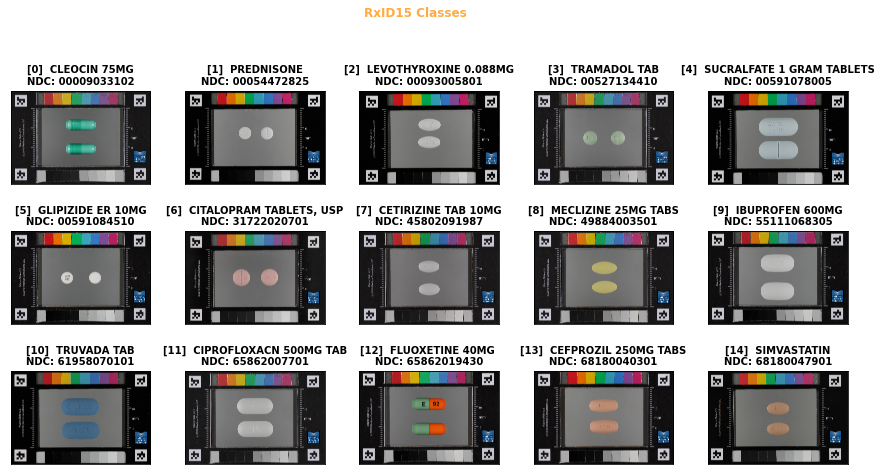

In [0]:
plt.figure(figsize=(15,11))
columns = 5
for i, image in enumerate(images): # iterate through the images in the array 'images'
    dname = df.DRUG[df.FILENAME.str.contains(samplefiles[i][:-4])].tolist()[0] # get the drug name from the df for the image in index i 
    dndc = df.NDC[df.FILENAME.str.contains(samplefiles[i][:-4])].tolist()[0] # get the NDC from the df for the image in index i 
    title = '[' + str(i) + '] ' + ' ' + dname + '\nNDC: ' + str(dndc) # title for each subplot: class, drug name, and NDC
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.subplots_adjust(hspace=0.05,wspace=0.25, top=.9, bottom=.2) # i believe this is the subplots spacing from each other and within the plot
    plt.margins(tight=True) # not sure which margins this is impacting
    plt.title(title,fontweight='semibold',fontsize='10')
    plt.imshow(image)
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    #plt.savefig('../../Images/classes3.jpg',format='jpg',quality=95,dpi=300, bbox='tight',pad_inches = 0) # bbox has always given me the output i wanted...

## Get Train/Test Images

These code blocks are where your dataset will be downloaded to your local directory.





In [0]:
drugsftp = df.FILE.tolist()
drugsftp.sort()
drugsftp[:10] # the list of files you are requesting from the ftp server

['PillProjectDisc1/images/!1ECEZFCQZ5I6S0RP6IZ-T!_6Y2RXW.PNG',
 'PillProjectDisc1/images/!AOKWIRBTDVYLX41JNYGUE1OPO6-15.JPG',
 'PillProjectDisc1/images/!ER_L-9UW4J0KP5FQTJ2-LQKM!FKUK.JPG',
 'PillProjectDisc1/images/!RASGCGC5SYGS!IO9BV7LGPDWRYAKC.PNG',
 'PillProjectDisc1/images/!RI!43F-63PT8X1IRKA_BXYNUQ4-IT.JPG',
 'PillProjectDisc1/images/!VNV0FNW6HS3ENSDUTBIKD-SFWCXIH.JPG',
 'PillProjectDisc1/images/!Y7FKLUPG3TK-OZ7A5EVQCVF420-VJ.PNG',
 'PillProjectDisc10/images/6JNJRHBSSKORD05NM42GEQJ9GL54JQ.JPG',
 'PillProjectDisc10/images/6U0QV!Q!2FKM31JEK-_-MFJL83CC8_.JPG',
 'PillProjectDisc10/images/6UFKARR8JAS2HO771K5QNIB0!_B019.JPG']

In [0]:
ftpdir = {}
for i in range(0,len(drugsftp)):
    ftpcall = drugsftp[i].split('/') #separate the folder from the file
    ftppath = ftpcall[0]+'/'+ftpcall[1]+ '/'
    ftpfile = ftpcall[-1] #isolate the filename
    ftpdir.setdefault(ftppath,[])
    ftpdir[ftppath].append(ftpfile) #create the folder:file pair
len(ftpdir)

110

In [0]:
dloaded = os.listdir() # get list of unprocessed images in the 'Download' folder
for key in ftpdir.keys():
    ftp = FTP('lhcftp.nlm.nih.gov')
    ftp.login()
    ftp.cwd('Open-Access-Datasets/Pills//')
    ftp.cwd(key)
    for value in ftpdir[key]:
        if value not in dloaded: # If your download is interrupted, this code block will check if you've already downloaded a file and skip it, saving some time
            with open(value, 'wb') as fp:
                ftp.retrbinary('RETR '+ value, fp.write)
    ftp.cwd('..')
    ftp.cwd('..')

#converting images to a smaller format JPG
for filename in os.listdir():
    if filename.endswith(".PNG") or filename.endswith(".JPG"): 
        im1 = Image.open(r'{}'.format(filename))
        rgb_im = im1.convert('RGB')
        rgb_im.save(r'{}.JPG'.format(filename[:-4]))
        continue
    elif filename.endswith(".CR2") and os.path.getsize(filename) > 0: # CR2 is a Canon professional image format; some files were corrupted and we will skip them
        raw = rawpy.imread('{}'.format(filename))
        rgb = raw.postprocess()
        imageio.imsave('{}.JPG'.format(filename[:-4]), rgb)
        continue
for filename in os.listdir():
    if filename.endswith(".PNG") or filename.endswith(".CR2"):
        os.remove(filename)
    elif os.path.isdir(filename):
        shutil.rmtree(filename)
    elif filename.startswith('.'):
        os.remove(filename)

## Sort Images by Class

In [0]:
df['FILENAME'] = df.FILENAME.str[:-4] + '.JPG' #all files are now .JPG in the local directory, updating df to reflect

In [0]:
%pwd

'/home/jupyter/RxID2/Data/Download'

In [0]:
%cd ..

/content/drive/My Drive/RxID2/Data


In [0]:
try:
    os.makedirs('Classes') #create a directory for this collection of drugs images 
except:
    print('Folder already created')

for img in os.listdir('Download'):
    try:
        folder = df.NDC[df.FILENAME == img].tolist()[0] # get the NDC for the drug being iterated
    except:
        print('{} not in df'.format(img)) # in case an errant file made it through, we dont want to add to our sorted directories
  
    try:
        classed = 'Classes/{}'.format(folder)
        os.mkdir(classed) # create a folder if it doesnt already exist
    except:
        continue
  
    try:
        origin = os.path.join('Download', img) # find our image in unclassed...
        destination = os.path.join(classed, img) #declare where we want to put it.... 
        shutil.copy(origin, destination) # and copy the file 
    except:
        print('Could not copy file {}'.format(img))

In [0]:
# finally we print our new class directories and their file counts 
for fldr in os.listdir('Classes'):
    files = len(os.listdir('Classes'+ '/' + fldr))
    print(fldr.title() + ' : ' + str(files))

45802091987 : 30
00591078005 : 36
65862019430 : 50
00591084510 : 50
61958070101 : 34
68180040301 : 28
49884003501 : 30
00093005801 : 67
55111068305 : 50
68180047901 : 34
31722020701 : 31
00009033102 : 50
00527134410 : 55
65862007701 : 28
00054472825 : 34


In [0]:
#shutil.rmtree('download') # delete the download images if desired

In [0]:
%pwd

'/home/jupyter/RxID/Data'

In [0]:
new_dir         = 'RxID2_split'

train_folder    = os.path.join(new_dir, 'train')
test_folder     = os.path.join(new_dir, 'test')
val_folder      = os.path.join(new_dir, 'validation')

try:
    os.mkdir(new_dir)
    os.mkdir(train_folder)
    os.mkdir(test_folder)
    os.mkdir(val_folder)
except:
    print('Folders already made')

In [0]:
for item in os.listdir('Classes'):
    class_train = os.path.join(train_folder, item)
    class_test  = os.path.join(test_folder, item)
    class_val  = os.path.join(val_folder, item)
    try:
        os.mkdir(class_train)
        os.mkdir(class_test)
        os.mkdir(class_val)
    except:
        print('Folders present')
  
    classdir = 'Classes/{}'.format( item)
    imgs_class = os.listdir(classdir)

    imgs = imgs_class[:20]
    for img in imgs:
        origin = os.path.join(classdir, img)
        destination = os.path.join(class_train, img)
        try:
            shutil.copyfile(origin, destination)
        except:
            continue
  
    imgs = imgs_class[20:25]
    for img in imgs:
        origin = os.path.join(classdir, img)
        destination = os.path.join(class_val, img)
        try:
            shutil.copyfile(origin, destination)
        except:
            continue
  
    imgs = imgs_class[25:30]
    for img in imgs:
        origin = os.path.join(classdir, img)
        destination = os.path.join(class_test, img)
        try:
            shutil.copyfile(origin, destination)
        except:
            continue

In [0]:
df

,NDC,IDK,FILE,TYPE,DRUG,ORIG_FOLDER,IMAGES,FILENAME,FILETYPE,NDC_prod
2946,00009033102,1,PillProjectDisc58/images/CB4CEJKI72-2IAAF8SPNK...,C3PI_Reference,CLEOCIN 75MG,PillProjectDisc58,images,CB4CEJKI72-2IAAF8SPNK-YD6QHSBHE.JPG,.CR2,000090331
2947,00009033102,1,PillProjectDisc95/images/MJ8SIXGLA!IDK6QKOJQ8N...,C3PI_Reference,CLEOCIN 75MG,PillProjectDisc95,images,MJ8SIXGLA!IDK6QKOJQ8N5DOBZIKHE.JPG,.CR2,000090331
2949,00009033102,1,PillProjectDisc107/images/XW27OGQ!GSTCS6SVCFSE...,C3PI_Test,CLEOCIN 75MG,PillProjectDisc107,images,XW27OGQ!GSTCS6SVCFSE6F!WHA7PYT.JPG,.JPG,000090331
2950,00009033102,1,PillProjectDisc13/images/9CLLUNVVKAJ4Y!Q0R_4_H...,C3PI_Test,CLEOCIN 75MG,PillProjectDisc13,images,9CLLUNVVKAJ4Y!Q0R_4_H0I4EVZG5C.JPG,.JPG,000090331
2951,00009033102,1,PillProjectDisc17/images/B18QCJP3ZMIWFPGXJZ4R3...,C3PI_Test,CLEOCIN 75MG,PillProjectDisc17,images,B18QCJP3ZMIWFPGXJZ4R3I-OL2GR6Z-.JPG,.JPG,000090331
...,...,...,...,...,...,...,...,...,...,...
127776,68180047901,1,PillProjectDisc42/images/BP4V9ZT0LMIB4BO872E-W...,MC_COOKED_CALIBRATED_V1.2,SIMVASTATIN,PillProjectDisc42,images,BP4V9ZT0LMIB4BO872E-WK025340X84.JPG,.PNG,681800479
127777,68180047901,1,PillProjectDisc51/images/BXRU3YZEHJU82Z4XML43I...,MC_COOKED_CALIBRATED_V1.2,SIMVASTATIN,PillProjectDisc51,images,BXRU3YZEHJU82Z4XML43IK7X1JWYWH7.JPG,.PNG,681800479
127778,68180047901,1,PillProjectDisc72/images/CN_3M1A3P5IO95ONJAKUI...,MC_COOKED_CALIBRATED_V1.2,SIMVASTATIN,PillProjectDisc72,images,CN_3M1A3P5IO95ONJAKUIFJYQC18Y9_.JPG,.PNG,681800479
127779,68180047901,1,PillProjectDisc83/images/CY8E7A05V71HWIUH2IQOZ...,MC_COOKED_CALIBRATED_V1.2,SIMVASTATIN,PillProjectDisc83,images,CY8E7A05V71HWIUH2IQOZYMM-2BJSD8.JPG,.PNG,681800479


In [0]:
df.to_csv('../Data/rxid15.csv')

# Modeling

In [0]:
df = pd.read_csv('/content/drive/My Drive/RxID2/Data/rxid15.csv')

In [0]:
train_folder = '/content/drive/My Drive/RxID2/Data/RxID2_split/train'
val_folder = '/content/drive/My Drive/RxID2/Data/RxID2_split/validation'
realworld_folder = '//content/drive/My Drive/RxID2/Data/RxID2_split/realworld2'

## CNN 1 (Baseline)

### Setup

In [0]:
BATCH_SIZE = 32
IMG_SHAPE  = 28 
EPOCHS = 50


val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder,
                                                                       shuffle=False,
                                                                       #class_mode='binary',
                                                                       target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                       batch_size = BATCH_SIZE)

train_generator = ImageDataGenerator(rescale=1./255,
                                    ).flow_from_directory(train_folder,
                                                                          shuffle=True,
                                                                          #class_mode='binary',
                                                                          target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                          batch_size=BATCH_SIZE)

realworld_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(realworld_folder,
                                                                       shuffle=False,
                                                                       class_mode='categorical',
                                                                       target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                       batch_size = BATCH_SIZE)
# labels = list((val_generator.class_indices).values())

Found 75 images belonging to 15 classes.
Found 300 images belonging to 15 classes.
Found 15 images belonging to 15 classes.


In [0]:
model = models.Sequential(name='rxv_cnn_1')

model.add(layers.Conv2D(128, (3,3), activation='relu',input_shape=(IMG_SHAPE ,IMG_SHAPE,  3)))
model.add(layers.MaxPooling2D((3, 3)))

model.add(layers.Conv2D(64, (3,3), activation='relu', padding="same"))
#model.add(layers.MaxPooling2D((3, 3))) 

model.add(layers.Flatten())
model.add(layers.Dense(15, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model.summary()

csv_logger = CSVLogger('/content/drive/My Drive/RxID2/Models/hist_{}.log'.format(model.name), separator=',', append=False)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

Model: "rxv_cnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 26, 26, 128)       3584      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 64)          73792     
_________________________________________________________________
flatten_9 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 15)                61455     
Total params: 138,831
Trainable params: 138,831
Non-trainable params: 0
_________________________________________________________________


### Training

In [0]:
history = model.fit(train_generator,
                    epochs=EPOCHS,
                    validation_data=val_generator,
                    callbacks=[early,csv_logger],
                    use_multiprocessing=True,
                    workers=multiprocessing.cpu_count(),
                    verbose=2)
model.save('/content/drive/My Drive/RxID2/Models/model_{}'.format(model.name))

### Analysis

In [0]:
hist = pd.read_csv('/content/drive/My Drive/RxID2/Models/hist_{}.log'.format(model.name), sep=',', engine='python')

model_scores(model)

real_world_predicts(model)

1/1 [==============================] - 2s 2s/step

Validation Accuracy: 74%
Real-world Accuracy: 13%

Real-world predictions 0-14:  [ 6  5  5 14  5  3  5  5  5 12 10 11  3  3  5]


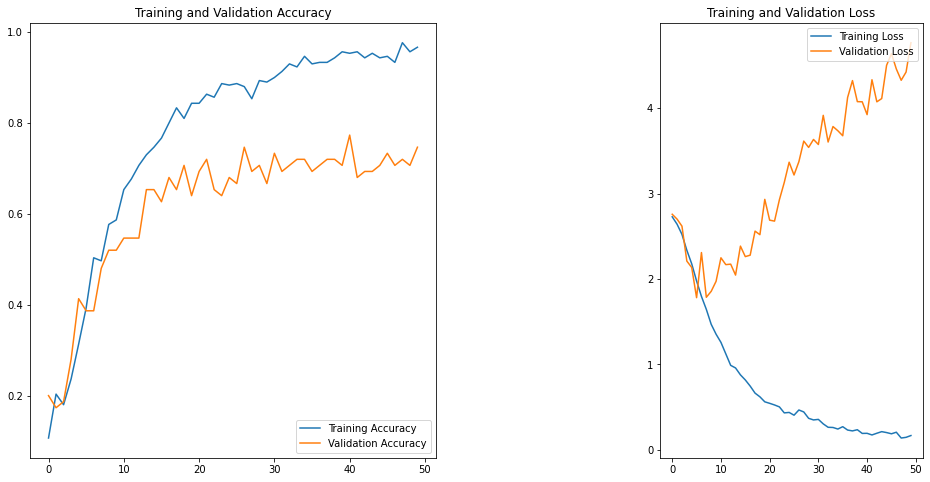

In [0]:
model_acc_val_plot(model)

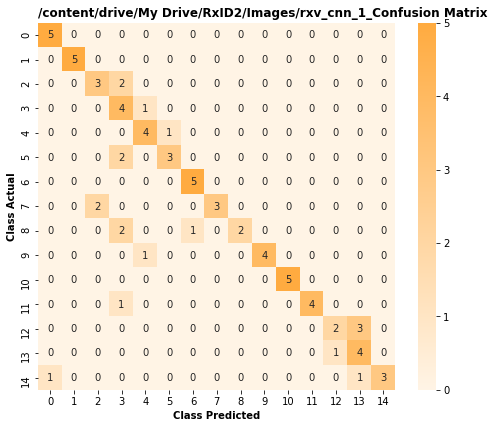

In [0]:
model_confusion(model)

/content/drive/My Drive/RxID2/Data/Download
/content/drive/My Drive/RxID2


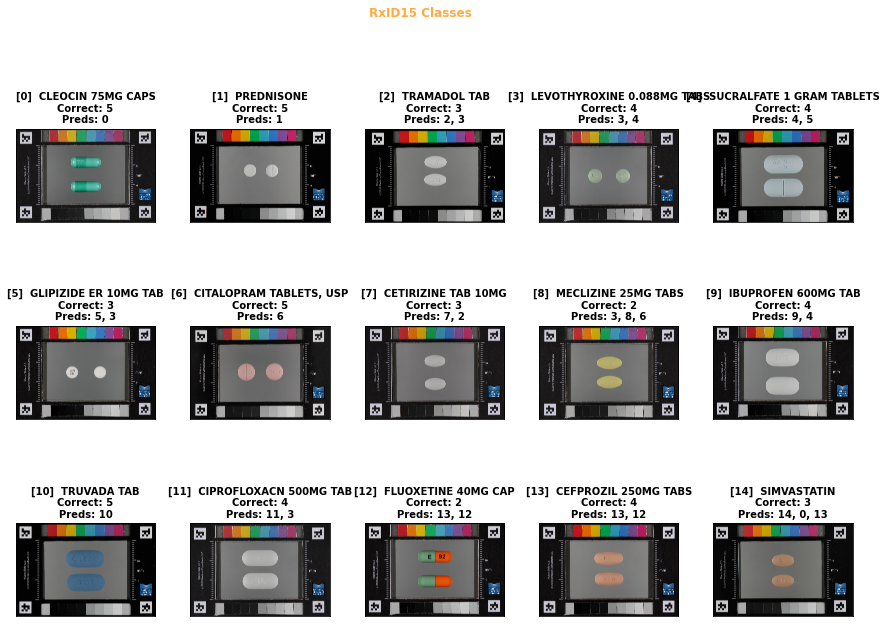

In [0]:
predict_plot(model)

## CNN 3

### Setup

In [0]:
BATCH_SIZE = 32
IMG_SHAPE  = 128 
EPOCHS =  100


val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder,
                                                                       shuffle=False,
                                                                       class_mode='categorical',
                                                                       target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                       batch_size = BATCH_SIZE)

train_generator = ImageDataGenerator(rescale=1./255,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     brightness_range=(.5,1.5),
                                     shear_range=0.2,
                                     rotation_range=45,
                                     vertical_flip=True,
                                     zoom_range=0.35).flow_from_directory(train_folder,
                                                                          shuffle=True,
                                                                          class_mode='categorical',
                                                                          target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                          batch_size=BATCH_SIZE)

realworld_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(realworld_folder,
                                                                       shuffle=False,
                                                                       class_mode='categorical',
                                                                       target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                       batch_size = BATCH_SIZE)
# labels = list((val_generator.class_indices).values())

Found 75 images belonging to 15 classes.
Found 300 images belonging to 15 classes.
Found 15 images belonging to 15 classes.


In [0]:
model = models.Sequential(name='rxv_cnn_3')

model.add(layers.Conv2D(1024, (3,3), activation='relu',input_shape=(IMG_SHAPE ,IMG_SHAPE,  3)))
model.add(layers.MaxPooling2D((3, 3)))

model.add(layers.Conv2D(512, (3,3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(256, (3,3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(256, (3,3), activation='relu', padding="same"))
#model.add(layers.MaxPooling2D((3, 3))) 

model.add(layers.Flatten())
model.add(layers.Dense(15, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',#optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
model.summary()

csv_logger = CSVLogger('/content/drive/My Drive/RxID2/Models/hist_{}.log'.format(model.name), separator=',', append=False)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
plat = ReduceLROnPlateau()

Model: "rxv_cnn_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 126, 126, 1024)    28672     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 42, 42, 1024)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 42, 42, 512)       4719104   
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 512)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 512)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 256)       1179904   
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 256)         0 

### Training

In [0]:
history = model.fit(train_generator,
                    epochs=EPOCHS,
                    validation_data=val_generator,
                    callbacks=[early,csv_logger],
                    use_multiprocessing=True,
                    workers=multiprocessing.cpu_count(),
                    verbose=2)
model.save('/content/drive/My Drive/RxID2/Models/model_{}'.format(model.name))

Epoch 1/100
 - 19s - loss: 2.7599 - acc: 0.0533 - val_loss: 2.7096 - val_acc: 0.0400
Epoch 2/100
 - 19s - loss: 2.7599 - acc: 0.0533 - val_loss: 2.7096 - val_acc: 0.0400
 - 15s - loss: 2.7098 - acc: 0.0800 - val_loss: 2.7121 - val_acc: 0.0533
Epoch 3/100
 - 16s - loss: 2.7068 - acc: 0.0833 - val_loss: 2.7263 - val_acc: 0.0933
Epoch 4/100
 - 17s - loss: 2.6901 - acc: 0.0600 - val_loss: 2.8290 - val_acc: 0.1067
Epoch 5/100
 - 17s - loss: 2.6901 - acc: 0.0600 - val_loss: 2.8290 - val_acc: 0.1067
 - 16s - loss: 2.6625 - acc: 0.1100 - val_loss: 2.6114 - val_acc: 0.1467
Epoch 6/100
 - 17s - loss: 2.6010 - acc: 0.1533 - val_loss: 2.4783 - val_acc: 0.2267
Epoch 7/100
 - 17s - loss: 2.6010 - acc: 0.1533 - val_loss: 2.4783 - val_acc: 0.2267
 - 17s - loss: 2.4967 - acc: 0.1667 - val_loss: 2.1641 - val_acc: 0.1333
Epoch 8/100
 - 17s - loss: 2.3722 - acc: 0.2100 - val_loss: 2.2734 - val_acc: 0.1467
Epoch 9/100
 - 16s - loss: 2.2833 - acc: 0.1633 - val_loss: 1.9622 - val_acc: 0.2667
Epoch 10/100
 - 

### Analysis

In [0]:
hist = pd.read_csv('/content/drive/My Drive/RxID2/Models/hist_{}.log'.format(model.name), sep=',', engine='python')

model_scores(model)

real_world_predicts(model)

1/1 [==============================] - 3s 3s/step

Validation Accuracy: 63%
Real-world Accuracy: 26%

Real-world predictions 0-14:  [ 0  7  5 14  5  7  6  6  5 13 10 11  6 14  1]


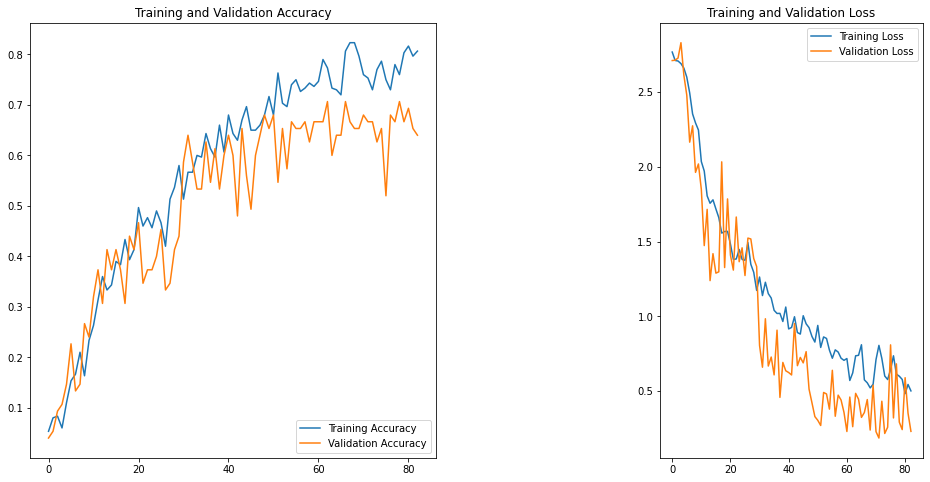

In [0]:
model_acc_val_plot(model)

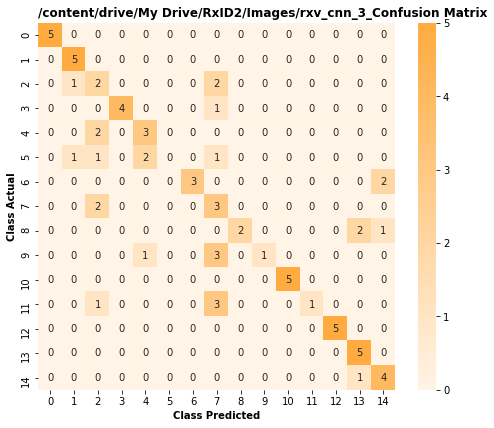

In [0]:
model_confusion(model)

/content/drive/My Drive/RxID2/Data/Download
/content/drive/My Drive/RxID2


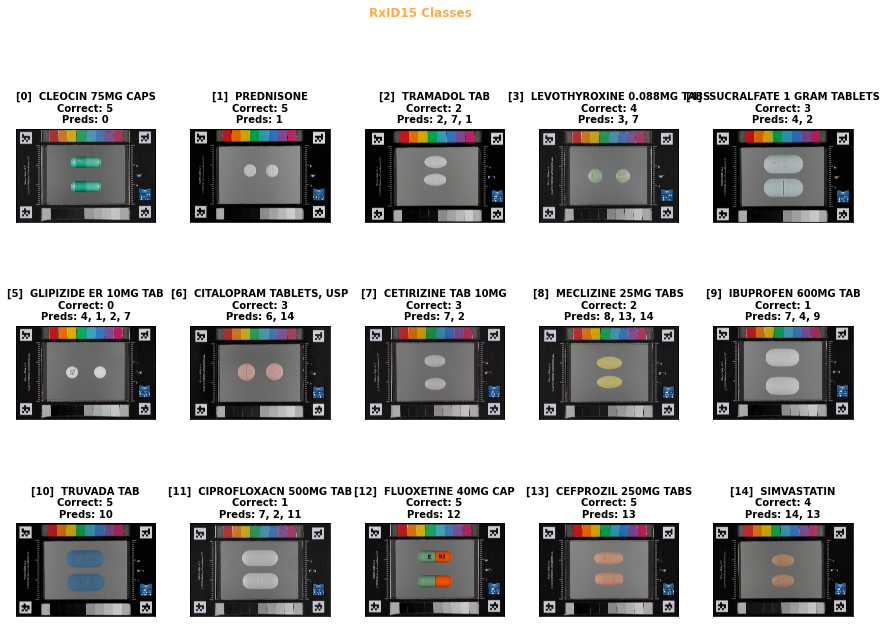

In [0]:
predict_plot(model)

## Final Model: CNN boosted with VGG16

### Setup

In [0]:
BATCH_SIZE = 24
IMG_SHAPE  = 224 
EPOCHS = 100 

realworld_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(realworld_folder,
                                                                       shuffle=False,
                                                                       class_mode='categorical',
                                                                       target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                       batch_size = BATCH_SIZE)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder,
                                                                       shuffle=False,
                                                                       class_mode='categorical',
                                                                       target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                       batch_size = BATCH_SIZE)

train_generator = ImageDataGenerator(rescale=1./255,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     brightness_range=(.5,1.5),
                                     shear_range=0.2,
                                     #channel_shift_range=128,
                                     rotation_range=45,
                                     vertical_flip=True,
                                     #fill_mode="nearest",
                                     zoom_range=(0.75,1.5)).flow_from_directory(train_folder,
                                                                          shuffle=True,
                                                                          class_mode='categorical',
                                                                          target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                          batch_size=BATCH_SIZE)

Found 15 images belonging to 15 classes.
Found 75 images belonging to 15 classes.
Found 300 images belonging to 15 classes.


In [0]:
from keras.applications import VGG16
cnn_model = VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SHAPE ,IMG_SHAPE,  3))
cnn_model.trainable = True


model = models.Sequential(name='rxv_vgg16_2')

model.add(cnn_model)
model.add(layers.MaxPooling2D((3, 3)))


model.add(layers.Conv2D(1024, (3,3), activation='relu', padding="same"))
#model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.SpatialDropout2D(0.1))

model.add(layers.Conv2D(512, (3,3), activation='relu', padding="same"))
#model.add(layers.ActivityRegularization(l1=0.0)
model.add(layers.Dropout(0.1))

model.add(layers.Conv2D(256, (3,3), activation='relu', padding="same"))
model.add(layers.GaussianNoise(2.0))

model.add(layers.Flatten())
model.add(layers.Dense(15, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
model.summary()

Model: "rxv_vgg16_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 1024)        4719616   
_________________________________________________________________
spatial_dropout2d_2 (Spatial (None, 2, 2, 1024)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 512)         4719104   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 2, 2, 256)         

### Training

In [0]:
csv_logger = CSVLogger('/content/drive/My Drive/RxID2/Models/hist_{}.log'.format(model.name), separator=',', append=False)


#checkpoint = ModelCheckpoint("../Models/{}{}.h5".format(model.name,random.randint(1,10000)), monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

history = model.fit(train_generator,
                    epochs=EPOCHS,
                    validation_data=val_generator,
                    callbacks=[early,csv_logger],
                    verbose=1,
                    use_multiprocessing=True,
                    workers=multiprocessing.cpu_count())
model.save('/content/drive/My Drive/RxID2/Models/model_{}'.format(model.name))

Epoch 1/100
13/13 [==============================] - 40s 3s/step - loss: 5.6021 - acc: 0.0500 - val_loss: 2.8309 - val_acc: 0.2667
Epoch 2/100
13/13 [==============================] - 34s 3s/step - loss: 5.0283 - acc: 0.1033 - val_loss: 2.8947 - val_acc: 0.2400
Epoch 3/100
13/13 [==============================] - 35s 3s/step - loss: 4.9493 - acc: 0.1133 - val_loss: 2.1431 - val_acc: 0.3200
Epoch 4/100
13/13 [==============================] - 34s 3s/step - loss: 3.9090 - acc: 0.2133 - val_loss: 2.5573 - val_acc: 0.4533
Epoch 5/100
13/13 [==============================] - 34s 3s/step - loss: 3.4620 - acc: 0.3167 - val_loss: 0.7942 - val_acc: 0.5067
Epoch 6/100
13/13 [==============================] - 35s 3s/step - loss: 3.2051 - acc: 0.3533 - val_loss: 0.8556 - val_acc: 0.4667
Epoch 7/100
13/13 [==============================] - 35s 3s/step - loss: 2.9349 - acc: 0.3900 - val_loss: 5.8073 - val_acc: 0.3733
Epoch 

### Analysis

In [0]:
hist = pd.read_csv('/content/drive/My Drive/RxID2/Models/hist_{}.log'.format(model.name), sep=',', engine='python')

model_scores(model)

real_world_predicts(model)

1/1 [==============================] - 3s 3s/step

Validation Accuracy: 92%
Real-world Accuracy: 40%

Real-world predictions 0-14:  [ 0  1  2  3 10  5  9  2  3 13  4 11 13 14  1]


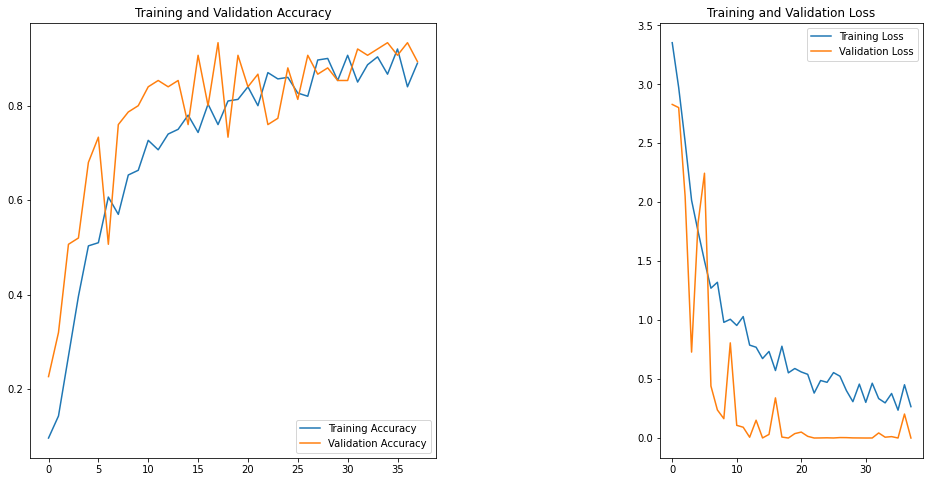

In [0]:
model_acc_val_plot(model)

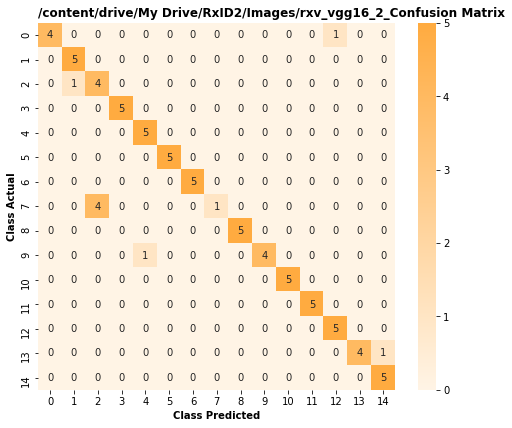

In [0]:
model_confusion(model)

/content/drive/My Drive/RxID2/Data/Download
/content/drive/My Drive/RxID2


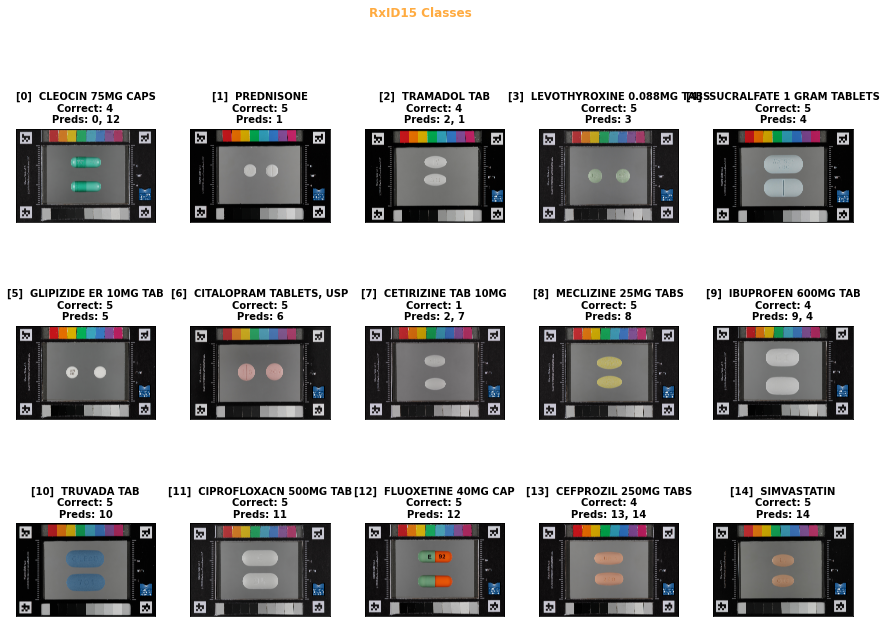

In [0]:
predict_plot(model)

**Idea:** duplicate the training images for each class ( x10?) to allow far more augmentations, without having to output augmentated images to a path